In [ ]:
# import shutil
# import os

# # Папки, которые нужно удалить
# folders_to_delete = ['/content/content','/content/merged_images','/content/all_class_0_images_with_contrast', '/content/all_class_0_images', '/content/augmented_images', '/content/temp_class_0_images', '/content/sample_data', '/content/augmented_class_0']

# for folder in folders_to_delete:
#     if os.path.exists(folder):
#         shutil.rmtree(folder)
#         print(f"Папка {folder} удалена.")
#     else:
#         print(f"Папка {folder} не существует.")

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import numpy as np
import warnings
from torchvision import transforms
from torchsummary import summary
from torchvision.io import read_image
import time
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import precision_score, recall_score, accuracy_score
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_file_path = '/content/drive/MyDrive/2_semestr/PP/annotations.zip'
# Распаковать архив в текущую папку
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [8]:
train_file = '/content/annotations/train_3classes.txt'
test_file = '/content/annotations/test_3classes.txt'
valid_file = '/content/annotations/valid_3classes.txt'

# Читаем TXT-файлы в DataFrame
train_df = pd.read_csv(train_file, sep=',', header=None, names=['картинка', 'класс'])
test_df = pd.read_csv(test_file, sep=',', header=None, names=['картинка', 'класс'])
valid_df = pd.read_csv(valid_file, sep=',', header=None, names=['картинка', 'класс'])

# Объединяем DataFrame
combined_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)

In [9]:
combined_df

,картинка,класс
0,4a32bd4c-147d-48b5-8d61-fc8865293247.3.jpg,1
1,36715475-f186-49a2-a195-e1a3b10caa29.7.jpg,2
2,0e79cb06-beb7-47cd-abf2-e00927748e3c.12.jpg,0
3,32af75c2-4cf6-47db-8fa1-47c0455a0bc4.7.jpg,0
4,8045b6ce-4d3a-447d-82ce-069417f4f7ff.12.jpg,1
...,...,...
494,4a32bd4c-147d-48b5-8d61-fc8865293247.12.jpg,1
495,41ea8744-371e-4581-9ba5-a02bef6ff7b8.4.jpg,2
496,526e8d5c-d5c6-4ffd-971d-b6de06c144ba.1.jpg,1
497,41ea8744-371e-4581-9ba5-a02bef6ff7b8.15.jpg,2


класс
1    297
2    126
0     76
Name: count, dtype: int64


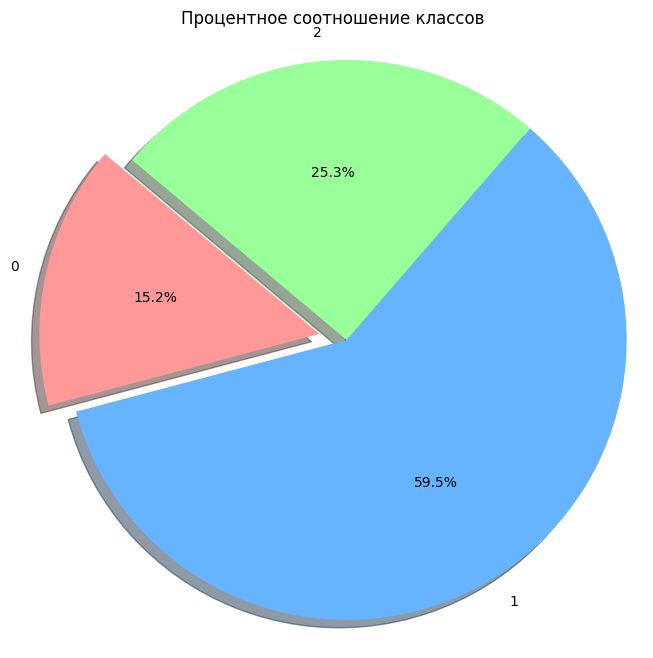

In [11]:
# Подсчет количества каждого класса
class_counts = combined_df['класс'].value_counts()
print(class_counts)
# Подготовка данных для круговой диаграммы
labels = ['0', '1', '2']
sizes = [class_counts[0], class_counts[1], class_counts[2]]
colors = ['#ff9999','#66b3ff', '#99ff99']
explode = (0.1, 0, 0)  # Взрыв первого куска для выделения

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Процентное соотношение классов')
plt.axis('equal')  # Круговая диаграмма выглядит как круг
plt.show()

In [16]:
# Фильтрация изображений класса 0
class_0_images = combined_df[combined_df['класс'] == 0]['картинка'].tolist()

# Предполагается, что изображения находятся в /content/annotations/images
image_directory = '/content/annotations/images'
class_0_images_paths = [os.path.join(image_directory, img) for img in class_0_images]

# Временная директория для изображений класса 0
temp_directory = 'temp_class_0_images'

# Удаление содержимого temp_directory, если оно существует
if os.path.exists(temp_directory):
    shutil.rmtree(temp_directory)
os.makedirs(temp_directory)

# Копирование изображений класса 0 во временную директорию
for image_path in class_0_images_paths:
    shutil.copy(image_path, temp_directory)

In [19]:
# Фильтрация combined_df по классу 1
class_1_2_df = combined_df[(combined_df['класс'] == 1) | (combined_df['класс'] == 2)]
class_1_2_df

,картинка,класс
0,4a32bd4c-147d-48b5-8d61-fc8865293247.3.jpg,1
1,36715475-f186-49a2-a195-e1a3b10caa29.7.jpg,2
4,8045b6ce-4d3a-447d-82ce-069417f4f7ff.12.jpg,1
5,2b47ca79-d753-42ab-9d3f-a48058fcdead.4.jpg,1
6,89cb4385-8258-4e8c-bad3-86673e04d882.8.jpg,1
...,...,...
494,4a32bd4c-147d-48b5-8d61-fc8865293247.12.jpg,1
495,41ea8744-371e-4581-9ba5-a02bef6ff7b8.4.jpg,2
496,526e8d5c-d5c6-4ffd-971d-b6de06c144ba.1.jpg,1
497,41ea8744-371e-4581-9ba5-a02bef6ff7b8.15.jpg,2


In [20]:
temp_directory = 'temp_class_0_images'

In [21]:
def count_files_in_directory(temp_directory):
# Проверка существования директории
    if os.path.exists(temp_directory):
        # Получение списка всех файлов в директории
        image_files = [f for f in os.listdir(temp_directory) if f.endswith(('.jpg', '.png'))]
        # Подсчёт количества файлов
        num_images = len(image_files)
        print(f"Количество изображений в {temp_directory}: {num_images}")
    else:
        print(f"Директория {temp_directory} не существует.")

In [22]:
count_files_in_directory(temp_directory)

Количество изображений в temp_class_0_images: 76


In [23]:
# взять изображение из временной папки
# применить к исходному контраст
# применить к исходному вертикаль
# сохранить вертикаль
# применить к исходному горизонталь
# сохранить горизонталь
# применить к контраст вертикаль
# сохранить вертикаль
# применить к контраст горизонталь
# сохранить горизонталь
# на выходе положить в папку: оригинал (76), вертикаль(76), горизонталь(76), контраст(76), вертикаль-контраст(76), горизонталь-контраст(76)
# 76*6 = 456

import os
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img

def flip_image(image_path, save_to_dir):
    """
    Функция для применения аугментации к изображению и сохранения результатов.

    Аргументы:
    - image_path: путь к изображению.
    - save_to_dir: директория для сохранения изменённых изображений.
    """
    image = load_img(image_path)
    data = img_to_array(image)
    data = data.reshape((1,) + data.shape)

    # Инициализация генераторов данных для различных типов аугментации
    datagen_contrast = ImageDataGenerator(brightness_range=(0.7, 1.3))
    datagen_vertical_flip = ImageDataGenerator(vertical_flip=True)
    datagen_horizontal_flip = ImageDataGenerator(horizontal_flip=True)

    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Применение контраста
    for batch in datagen_contrast.flow(data, batch_size=1):
        contrast_image = batch[0]
        break

    # Сохранение оригинала
    image.save(os.path.join(save_to_dir, f"{base_name}_original.jpg"))

    # Сохранение контрастного изображения
    array_to_img(contrast_image).save(os.path.join(save_to_dir, f"{base_name}_contrast.jpg"))

    # Применение вертикального флипа и сохранение
    for batch in datagen_vertical_flip.flow(data, batch_size=1):
        vertical_image = batch[0]
        break
    array_to_img(vertical_image).save(os.path.join(save_to_dir, f"{base_name}_vertical.jpg"))

    # Применение горизонтального флипа и сохранение
    for batch in datagen_horizontal_flip.flow(data, batch_size=1):
        horizontal_image = batch[0]
        break
    array_to_img(horizontal_image).save(os.path.join(save_to_dir, f"{base_name}_horizontal.jpg"))

    # Применение вертикального флипа к контрастному изображению и сохранение
    contrast_image = contrast_image.reshape((1,) + contrast_image.shape)
    for batch in datagen_vertical_flip.flow(contrast_image, batch_size=1):
        vertical_contrast_image = batch[0]
        break
    array_to_img(vertical_contrast_image).save(os.path.join(save_to_dir, f"{base_name}_vertical_contrast.jpg"))

    # Применение горизонтального флипа к контрастному изображению и сохранение
    for batch in datagen_horizontal_flip.flow(contrast_image, batch_size=1):
        horizontal_contrast_image = batch[0]
        break
    array_to_img(horizontal_contrast_image).save(os.path.join(save_to_dir, f"{base_name}_horizontal_contrast.jpg"))

def process_images(source_dir, target_dir):
    """
    Функция для обработки всех изображений в директории.

    Аргументы:
    - source_dir: исходная директория с изображениями.
    - target_dir: целевая директория для сохранения изменённых изображений.
    """
    os.makedirs(target_dir, exist_ok=True)

    for filename in os.listdir(source_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(source_dir, filename)
            flip_image(image_path, target_dir)

# Пример использования функции для обработки всех изображений в папке
source_directory = '/content/temp_class_0_images'
target_directory = '/content/augmented_images'

# Обработка изображений

process_images(source_directory, target_directory)

# Проверка количества файлов
num_files = len([name for name in os.listdir(target_directory) if os.path.isfile(os.path.join(target_directory, name))])
print(f"Количество файлов в {target_directory}: {num_files}")



Количество файлов в /content/augmented_images: 456


In [24]:
# Получить список изображений в исходной папке
images_0 = os.listdir(target_directory)

# Создать датафрейм с колонками "имя_файла" и "класс"
df_0 = pd.DataFrame({"картинка": images_0, "класс": 0})
df_0

,картинка,класс
0,0e79cb06-beb7-47cd-abf2-e00927748e3c.1_contras...,0
1,da55f4c7-db52-4850-966f-fab386a8a45e.3_horizon...,0
2,32af75c2-4cf6-47db-8fa1-47c0455a0bc4.2_contras...,0
3,4608554f-8743-4ecb-88a1-8c008a64e412.5_vertica...,0
4,4c8dbebc-ea99-47b1-818d-6036769bc811.5_horizon...,0
...,...,...
451,da55f4c7-db52-4850-966f-fab386a8a45e.5_contras...,0
452,0e79cb06-beb7-47cd-abf2-e00927748e3c.4_vertica...,0
453,8d096f42-7ee6-4647-84b7-e59c9d5dab7c.2_horizon...,0
454,4608554f-8743-4ecb-88a1-8c008a64e412.7_origina...,0


In [30]:
# Фильтрация изображений класса 1
class_1_images = combined_df[combined_df['класс'] == 1]['картинка'].tolist()

# Предполагается, что изображения находятся в /content/annotations/images
class_1_images_paths = [os.path.join(image_directory, img) for img in class_1_images]

# Временная директория для изображений класса 0
temp_directory = 'temp_class_1_images'

# Удаление содержимого temp_directory, если оно существует
if os.path.exists(temp_directory):
    shutil.rmtree(temp_directory)
os.makedirs(temp_directory)

# Копирование изображений класса 0 во временную директорию
for image_path in class_1_images_paths:
    shutil.copy(image_path, temp_directory)

In [31]:
count_files_in_directory(temp_directory)

Количество изображений в temp_class_1_images: 297


In [32]:
# Фильтрация изображений класса 2
class_2_images = combined_df[combined_df['класс'] == 2]['картинка'].tolist()

# Предполагается, что изображения находятся в /content/annotations/images
class_2_images_paths = [os.path.join(image_directory, img) for img in class_2_images]

# Временная директория для изображений класса 0
temp_directory_2 = 'temp_class_2_images'

# Удаление содержимого temp_directory, если оно существует
if os.path.exists(temp_directory_2):
    shutil.rmtree(temp_directory_2)
os.makedirs(temp_directory_2)

# Копирование изображений класса 0 во временную директорию
for image_path in class_2_images_paths:
    shutil.copy(image_path, temp_directory_2)

In [33]:
count_files_in_directory(temp_directory_2)

Количество изображений в temp_class_2_images: 126


In [34]:
# Пройтись по всем файлам в исходной папке
def run_dir(temp_directory):
    for filename in os.listdir(temp_directory):
        # Проверить, является ли файл изображением (jpg или png)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Создать полный путь к файлу в исходной и целевой папках
            src_path = os.path.join(temp_directory, filename)
            dst_path = os.path.join(target_directory, filename)

            # Переместить файл из исходной папки в целевую папку
            shutil.move(src_path, dst_path)

In [35]:
run_dir(temp_directory)
run_dir(temp_directory_2)

In [38]:
count_files_in_directory(target_directory)

Количество изображений в /content/augmented_images: 879


In [36]:
df = pd.concat([df_0, class_1_2_df], ignore_index=True)
df

,картинка,класс
0,0e79cb06-beb7-47cd-abf2-e00927748e3c.1_contras...,0
1,da55f4c7-db52-4850-966f-fab386a8a45e.3_horizon...,0
2,32af75c2-4cf6-47db-8fa1-47c0455a0bc4.2_contras...,0
3,4608554f-8743-4ecb-88a1-8c008a64e412.5_vertica...,0
4,4c8dbebc-ea99-47b1-818d-6036769bc811.5_horizon...,0
...,...,...
874,4a32bd4c-147d-48b5-8d61-fc8865293247.12.jpg,1
875,41ea8744-371e-4581-9ba5-a02bef6ff7b8.4.jpg,2
876,526e8d5c-d5c6-4ffd-971d-b6de06c144ba.1.jpg,1
877,41ea8744-371e-4581-9ba5-a02bef6ff7b8.15.jpg,2


класс
0    456
1    297
2    126
Name: count, dtype: int64


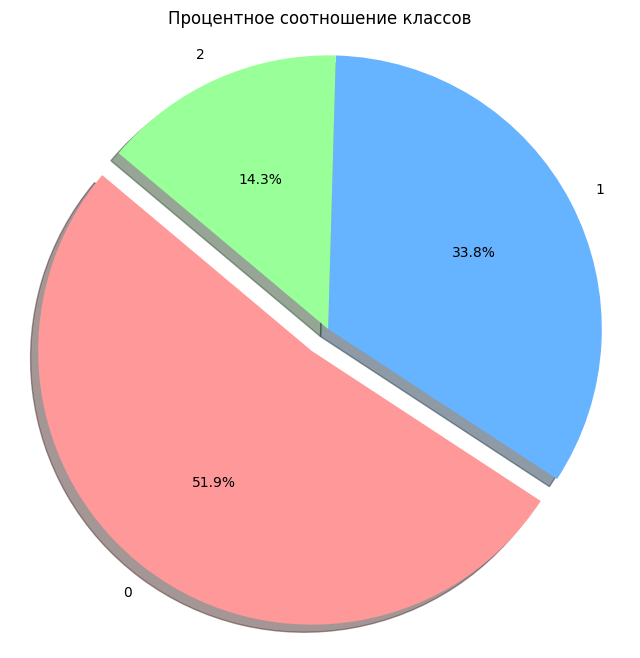

In [39]:
# Подсчет количества каждого класса
class_counts = df['класс'].value_counts()
print(class_counts)
# Подготовка данных для круговой диаграммы
labels = ['0', '1', '2']
sizes = [class_counts[0], class_counts[1], class_counts[2]]
colors = ['#ff9999','#66b3ff', '#99ff99']
explode = (0.1, 0, 0)  # Взрыв первого куска для выделения

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Процентное соотношение классов')
plt.axis('equal')  # Круговая диаграмма выглядит как круг
plt.show()